In [19]:
# Use Python 3.12!
# -q flag used to suppress useless output
!pip -q install numpy matplotlib qutip ipywidgets scipy pillow ipykernel

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as mpl_animation
from matplotlib import rc
from qutip import *
from ipywidgets import interact, FloatSlider, Checkbox, Dropdown, widgets
import ipywidgets as widgets
from IPython.display import display, Image, clear_output

rc('animation', html='jshtml')
plt.rcParams['animation.embed_limit'] = 90.0

w = 1.0 * 2 * np.pi  # Qubit frequency = 1 Hz
J = 0.5 * 2 * np.pi  # Coupling strength between qubits = 0.5 Hz = the exchange (Vacuum Rabi) frequency
gamma = 0.2          # Decay rate (dissipation strength)
# Characteristic lifetime of the system: T1 ~ 1/gamma => "Death" happens after ~ 5s

times = np.linspace(0, 10, 200) # [0.0, 0.05, 0.1, ..., 9.95, 10.0]

# 2-qubit Hilber space (4 dimensions)
# |00> = |0> x |0> = (1,0,0,0)
# |01> = |0> x |1> = (0,1,0,0)
# |10> = |1> x |0> = (0,0,1,0)
# |11> = |1> x |1> = (0,0,0,1)

# Qubit 1 operators (act on 1st subspace and leave 2nd subspace unchanged)
sz1 = tensor(sigmaz(), qeye(2)) # Measure Z-Spin (here equivalent to measuring the Energy)
sp1 = tensor(sigmap(), qeye(2)) # Raising
sm1 = tensor(sigmam(), qeye(2)) # Lowering (decay)

# Qubit 2 operators (act on 2nd subspace and leave 1st subspace unchanged)
sz2 = tensor(qeye(2), sigmaz()) # Measure Z-Spin (here equivalent to measuring the Energy)
sp2 = tensor(qeye(2), sigmap()) # Raising
sm2 = tensor(qeye(2), sigmam()) # Lowering (decay)

# The Hamiltonian = Individual energies + Interaction term (Exchange interaction)
H = J * (sm1 * sp2 + sp1 * sm2)

In [20]:
def get_bloch_vectors(result):
    # Define operators for Qubit 1 (acts on first space, identity on second)
    sx1 = tensor(sigmax(), qeye(2))
    sy1 = tensor(sigmay(), qeye(2))
    sz1 = tensor(sigmaz(), qeye(2))

    # Define operators for Qubit 2 (identity on first, acts on second
    sx2 = tensor(qeye(2), sigmax())
    sy2 = tensor(qeye(2), sigmay())
    sz2 = tensor(qeye(2), sigmaz())

    # Lists to store bloch vectors [x, y, z] for every time step
    vectors_q1 = []
    vectors_q2 = []

    for rho in result.states:
        # Calculate expectation values
        # Qubit 1
        v1 = [expect(sx1, rho), expect(sy1, rho), expect(sz1, rho)]

        # Qubit 2
        v2 = [expect(sx2, rho), expect(sy2, rho), expect(sz2, rho)]

        vectors_q1.append(v1)
        vectors_q2.append(v2)

    return np.array(vectors_q1), np.array(vectors_q2)

def visualize_electron_spins(result_A, sphere_color):
    # Get data
    vecs_q1, vecs_q2 = get_bloch_vectors(result_A)

    # Setup Figure
    fig = plt.figure(figsize=(6, 6))
    b = Bloch(fig=fig)
    b.vector_color = ['r', 'b']
    b.point_color = ['r', 'b']
    b.point_marker = ['o']
    b.sphere_color = sphere_color


    # Initial draw
    b.make_sphere()

    def animate(i):
        b.clear()

        # Qubit 1 (Red)
        b.add_vectors(vecs_q1[i])
        # only draw line if we have at least 2 points (i > 0)
        if i > 0:
            b.add_points([vecs_q1[:i+1, 0], vecs_q1[:i+1, 1], vecs_q1[:i+1, 2]], meth='l')

        # Qubit 2 (Blue)
        b.add_vectors(vecs_q2[i])
        if i > 0:
            b.add_points([vecs_q2[:i+1, 0], vecs_q2[:i+1, 1], vecs_q2[:i+1, 2]], meth='l')

        b.make_sphere()
        return []

    # Create Animation
    anim = mpl_animation.FuncAnimation(fig, animate, frames=len(vecs_q1), blit=False)
    print("Rendering GIF...")
    anim.save('spin_dynamics.gif', writer='pillow', fps=10)

    plt.close(fig)
    display(Image(filename='spin_dynamics.gif'))

def visualise_bloch_sphere(psi):
    c_ops = [np.sqrt(gamma) * (sm1 + sm2)]
    result = mesolve(H, psi, times, c_ops)
    visualize_electron_spins(result, '#0000FF15')

def visualise_cityscape(result_A, result_B, case, noise_type):
    """Create cityscape animations for both scenarios A and B"""
    from mpl_toolkits.mplot3d import Axes3D
    
    labels = ['|00⟩', '|01⟩', '|10⟩', '|11⟩']
    n = 4
    xpos, ypos = np.meshgrid(np.arange(n), np.arange(n))
    xpos = xpos.flatten()
    ypos = ypos.flatten()
    zpos = np.zeros(n * n)
    dx = dy = 0.6 * np.ones(n * n)
    
    # Color: diagonal = blue (populations), off-diagonal = red (coherences)
    colors_base = []
    for i in range(n):
        for j in range(n):
            if i == j:
                colors_base.append('#2563eb')  # Blue for diagonal (populations)
            else:
                colors_base.append('#dc2626')  # Red for off-diagonal (coherences)
    
    def create_cityscape_gif(result, title, filename):
        fig = plt.figure(figsize=(8, 6))
        
        def update(frame):
            fig.clf()
            ax = fig.add_subplot(111, projection='3d')
            
            rho = result.states[frame]
            rho_abs = np.abs(rho.full()).flatten()
            
            # Vary alpha based on magnitude for visual effect
            colors = []
            for idx, (c, val) in enumerate(zip(colors_base, rho_abs)):
                alpha = max(0.3, min(1.0, val + 0.3))
                if colors_base[idx] == '#2563eb':
                    colors.append((0.145, 0.388, 0.922, alpha))  # Blue with alpha
                else:
                    colors.append((0.863, 0.149, 0.149, alpha))  # Red with alpha
            
            ax.bar3d(xpos, ypos, zpos, dx, dy, rho_abs, color=colors, edgecolor='black', linewidth=0.3)
            
            ax.set_xlabel('Column')
            ax.set_ylabel('Row')
            ax.set_zlabel('|ρᵢⱼ|')
            ax.set_zlim(0, 0.6)
            ax.set_xticks(np.arange(n) + 0.3)
            ax.set_yticks(np.arange(n) + 0.3)
            ax.set_xticklabels(labels)
            ax.set_yticklabels(labels)
            ax.view_init(elev=25, azim=45)
            ax.set_title(f"{title}\nt = {times[frame]:.2f}s\n[BLUE] Populations    [RED] Coherences", fontsize=10)
        
        ani = mpl_animation.FuncAnimation(fig, update, frames=len(result.states), interval=80)
        print(f"Rendering {filename}...")
        ani.save(filename, writer='pillow', fps=12)
        plt.close(fig)
        return filename
    
    # Create both GIFs
    safe_case = case.replace(" ", "_").replace("(", "").replace(")", "")
    gif_a = create_cityscape_gif(result_A, f'{case}\nIndependent Baths ({noise_type})', f'cityscape_{safe_case}_{noise_type}_independent.gif')
    gif_b = create_cityscape_gif(result_B, f'{case}\nCommon Bath ({noise_type})', f'cityscape_{safe_case}_{noise_type}_common.gif')
    
    # Display both
    print(f"\n🏙️ Cityscape A: Independent Baths ({noise_type})")
    display(Image(filename=gif_a))
    print(f"\n🏙️ Cityscape B: Common Bath ({noise_type})")
    display(Image(filename=gif_b))

def simulate_sigma_m(psi, case):
    # Scenario A: Independent (Two separate "spies", blind to phase)
    c_ops_A = [np.sqrt(gamma) * sm1, np.sqrt(gamma) * sm2]

    # Scenario B: Common (One collective "spy", sensitive to phase)
    c_ops_B = [np.sqrt(gamma) * (sm1 + sm2)]

    # Simulations
    result_A = mesolve(H, psi, times, c_ops_A) # uses the Lindblad Master Equation
    result_B = mesolve(H, psi, times, c_ops_B)

    # Entanglement
    conc_A = [concurrence(rho) for rho in result_A.states]
    conc_B = [concurrence(rho) for rho in result_B.states]

    plt.figure(figsize=(10, 6))
    plt.plot(times, conc_A, label='A: Independent (Two separate "spies", blind to phase)')
    plt.plot(times, conc_B, label='B: Common (One collective "spy", sensitive to phase)')
    plt.axhline(0, color='k', linewidth=0.5)
    plt.title(f'Decoherence Effect: {case} with Energy Loss')
    plt.xlabel('Time (s)')
    plt.ylabel('Entanglement (Concurrence)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Show cityscapes
    visualise_cityscape(result_A, result_B, case, "Energy_Loss")

    return

def simulate_sigma_z(psi, case):
    # Scenario A: Independent (Two separate "spies", blind to phase)
    c_ops_A = [np.sqrt(gamma) * sz1, np.sqrt(gamma) * sz2]

    # Scenario B: Common (One collective "spy", sensitive to phase)
    c_ops_B = [np.sqrt(gamma) * (sz1 + sz2)]

    # Simulations
    result_A = mesolve(H, psi, times, c_ops_A) # uses the Lindblad Master Equation
    result_B = mesolve(H, psi, times, c_ops_B)

    # Entanglement
    conc_A = [concurrence(rho) for rho in result_A.states]
    conc_B = [concurrence(rho) for rho in result_B.states]

    plt.figure(figsize=(10, 6))
    plt.plot(times, conc_A, label='A: Independent (Two separate "spies", blind to phase)')
    plt.plot(times, conc_B, label='B: Common (One collective "spy", sensitive to phase)')
    plt.axhline(0, color='k', linewidth=0.5)
    plt.title(f'Decoherence Effect: {case} with Dephasing')
    plt.xlabel('Time (s)')
    plt.ylabel('Entanglement (Concurrence)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Show cityscapes
    visualise_cityscape(result_A, result_B, case, "Dephasing")

    return 

# Initial States
# Tried to use Qobj([0, 1, 1, 0]), but then you need to manually specify dims
# Symmetric (Triplet) - "Bright"
psi_bright = (ket("01") + ket("10")).unit()

# Antisymmetric (Singlet) - "Dark"
psi_dark = (ket("01") - ket("10")).unit()

# visualise_bloch_sphere(simulate(psi_bright))

# visualise_bloch_sphere(simulate(psi_dark))



In [21]:
# ==============================================================================
# 1. SUPPORTING FUNCTIONS (Projection & Visualisation)
# ==============================================================================

def project_to_logical_subspace(states):
    """
    Projects 4x4 matrix to 2x2 logical matrix
    Logical 0 = |01>, Logical 1 = |10>
    """
    logical_states = []
    for rho in states:
        if isket(rho): rho = ket2dm(rho)
        data = rho.full()
        
        # Project on index 1 (|01>) and index 2 (|10>)
        rho_logical_data = np.array([
            [data[1,1], data[1,2]],
            [data[2,1], data[2,2]]
        ])
             
        logical_states.append(Qobj(rho_logical_data))
    return logical_states

def visualize_logical_bloch(result, title, color_style):
    logical_states = project_to_logical_subspace(result.states)
    
    xp, yp, zp = [], [], []
    for rho in logical_states:
        xp.append(float(np.real(expect(sigmax(), rho))))
        yp.append(float(np.real(expect(sigmay(), rho))))
        zp.append(float(np.real(expect(sigmaz(), rho))))
    
    fig = plt.figure(figsize=(6, 6))
    b = Bloch(fig=fig)
    b.zlabel = ['$|0_L\\rangle$', '$|1_L\\rangle$']
    b.xlabel = ['$|+\\rangle_L$', '$|-\\rangle_L$']
    b.title = title
    b.point_color = [color_style]; b.point_marker = ['o']; b.point_size = [20]
    b.vector_color = [color_style]; b.view = [-40, 30]
    
    if len(xp) > 0:
        b.add_points([xp, yp, zp], meth='s')
        b.add_vectors([xp[-1], yp[-1], zp[-1]])
    
    b.show()
    plt.close() # Prevents double plot

# ==============================================================================
# 2. MAIN FUNCTION (SIMULATION)
# ==============================================================================

def run_advanced_demo(gamma_val, enable_phase, enable_energy, protection_mode):
    
    # --- A. Setup ---
    psi_0L = tensor(basis(2, 0), basis(2, 1)) # Start op |01> (Noordpool)
    times = np.linspace(0, 10, 100)
    
    # Hamiltonian (Logical X-gate / Exchange Interaction)
    w = 1.0 * 2 * np.pi
    J = 0.5 * 2 * np.pi
    
    # Define operators
    sz1 = tensor(sigmaz(), qeye(2)); sz2 = tensor(qeye(2), sigmaz())
    sm1 = tensor(sigmam(), qeye(2)); sm2 = tensor(qeye(2), sigmam())
    sp1 = tensor(sigmap(), qeye(2)); sp2 = tensor(qeye(2), sigmap())
    
    H_sys = 0.5 * w * (sz1 + sz2) + J * (sm1 * sp2 + sp1 * sm2)
    
    # --- B. Noise ---
    c_ops = []
    is_common = (protection_mode == 'Common Bath (DFS)')
    
    # 1. Phase Noise (Dephasing - Z)
    if enable_phase:
        if is_common:
            # DFS beschermt hiertegen! (Z1 + Z2) op |01> is 0.
            c_ops.append(np.sqrt(gamma_val) * (sz1 + sz2))
        else:
            # Separate bath: funest voor fase
            c_ops.append(np.sqrt(gamma_val) * sz1)
            c_ops.append(np.sqrt(gamma_val) * sz2)
            
    # 2. Energy Loss (Dissipation - Sigma Minus)
    if enable_energy:
        if is_common:
            # DFS beschermt hier NIET tegen! (Lekt naar |00>)
            c_ops.append(np.sqrt(gamma_val) * (sm1 + sm2))
        else:
            # Separate bath: ook lekkage
            c_ops.append(np.sqrt(gamma_val) * sm1)
            c_ops.append(np.sqrt(gamma_val) * sm2)

    # Title and color plot
    if is_common:
        title = "Mode: DFS Protected"
        color = 'g'
    else:
        title = "Mode: Unprotected"
        color = 'r'
        
    if not c_ops:
        title += " (No Noise)"

    # --- C. Simulation ---
    result = mesolve(H_sys, psi_0L, times, c_ops, [])
    
    # --- D. Visualisation Bloch Sphere ---
    visualize_logical_bloch(result, title, color)
    
    # --- E. Purity Plot (Vector Length) ---
    log_states = project_to_logical_subspace(result.states)
    purities = []
    
    for rho in log_states:
        vx = float(expect(sigmax(), rho))
        vy = float(expect(sigmay(), rho))
        vz = float(expect(sigmaz(), rho))
        
        length = np.sqrt(vx**2 + vy**2 + vz**2)
        purities.append(length)
    
    plt.figure(figsize=(10,4))
    plt.plot(times, purities, color=color, linewidth=2, label='Measured Purity')
    plt.ylim(0, 1.1)
    plt.title("Logical Vector Length (Information Retention)")
    plt.xlabel("Time")
    plt.ylabel("Length (r)")
    plt.axhline(1.0, color='k', linestyle='--', alpha=0.5, label='Ideal Unitary')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()



# **Final Project TN3156**
## **Authors: Matei Canavea, Casian Chiriac, Teodor Neagoe, Ivo van der Dussen (Group 13)**
# Two coupled TLS: the effect of decoherence on entanglement

## Introduction
One of the major difficulties of quantum computing is the decoherence of Two Level Systems (TLS). This loss of information is non reversible and thus creates issues with information processing inside a quantum computer. From this, it is easy to see why preventing decoherence is of great importance in this field of computing.<br><br>
One of the main causes of decoherence is noise. Noise causes dephasing in a qubit and thus leads to loss of information. For this project, a system of two coupled TLS's will be discussed. We will show how noise affects this two TLS system and simulate the system in QuTiP with varying parameters to find the most coherent system.<br><br>

## Description of the Physical Problem Being Simulated
Like mentioned before, our open system consists of two identical TLS's (e.g. Transmon Qubits, Spin Qubits etc.) which are coupled to eachother and thus, are able to exchange information. We will model the environment in 2 different ways: 1 collective "bath", which contains both TLS's and 2 seperate baths, each containing 1 TLS. In addition, we will also test 2 different kinds of subspaces: the singlet subspace and the triplet subspace. From testing all combinations of these parameters, we will be able to find the most noise-resistant configuration for our system.<br><br>

For this system, we use a Hamiltonian with some approximations: $H = H_0 + H_1 + H_{int}$. The important piece of this Hamiltonian is $H_{int}$. This interaction Hamiltonian looks like this after approximations: $H_{int} = J(\sigma_{+}^{(1)}\sigma_{-}^{(2)} + h.c.)$. For this Hamiltonian, the Rotating-Wave Approximation (RWA) was used. If we assume $J << \omega$ , we can neglect terms that don't conserve energy (like $\sigma_{+}^{(1)}\sigma_{+}^{(2)}$ and $\sigma_{-}^{(1)}\sigma_{-}^{(2)}$), since these terms oscillate rapidly, thus being able to be equated to 0. Also, we apply the TLS approximation, stating that the qubits are perfect Two Level Systems, thus ignoring leakage to higher levels (such as $\ket{2}$, $\ket{3}$ etc.). Finally, like mentioned before, we assume 2 identical qubits, with exactly the same energy levels.<br><br>

Based on physical intuition, we expect the system in the singlet subspace with the collective bath to be most resilient to noise, because of the anti-symmetrical nature of the singlet state and the symmetrical interaction to noise between both TLS's, respectively.<br><br>

## Aim and Scope of the Project
The main goal of this project is noise reduction. Using simulations inside of QuTiP, we will try to answer the following questions:
-  Is it possible to make the system consisting of two TLS's insensitive to noise with our parameters?
-  Against what kind of noise can our system be protected?
-  What would happen if we were to use more qubits?<br><br>

## Techniques and Approach

To answer these questions, we will plot concurrence graphs, to see how entanglement evolves through time while noise acts as decoherence. Concurrence is a measure of entanglement, ranging from 0 (no entanglement) to 1 (maximal entanglement). To calculate concurrence, we have defined a simplified interaction Hamiltonian using raising and lowering operators, like mentioned before. We use the concurrence() function, which is specifically defined for a 2-qubit system. The concurrence() function uses Wootters formula for calculating concurrence. This formula takes the density matrix of the system, multiplies it with it's own spin-flipped version and calculates all eigenvalues of the resulting matrix. All eigenvalues are then combined and a single value for concurrence is obtained: $C(\rho) = \max\{0, \lambda_1 - \lambda_2 - \lambda_3 ...\}$. (_W. K. Wootters (1998), “Entanglement of Formation of an Arbitrary State of Two Qubits”_)

To plot the concurrence against time, we use the Lindblad Master Equation to evolve the state vector $\ket{\Psi}$ through time. The Lindblad Master Equation can be solved in QuTiP by using the function mesolve(). After supplying this function with arguments H (Hamiltonian), $\rho_0$ (initial state vector or density matrix) and c_ops (collapse operator, in our case $\sigma_-$), the function uses $\dot{\rho} = \frac{i}{\hbar}[H, \rho] + \sum\limits_{i}\gamma_{i}(L_{i} \rho L_{i}^{\dagger} - \frac{1}{2} \{L_{i}^{\dagger} L_{i}, \rho\})$. (_G. Lindblad (1976), "On the generators of quantum dynamical semigroups", for the Lindbladian and QuTiP documentation (https://qutip.org/docs/4.0.2/modules/qutip/mesolve.html) to get the time evolution of the state, which we can then plug into the concurrence() function_)

For additional visualisation, we can also plot the Bloch sphere:
-  The Bloch sphere can easily be plotted using bloch(). This class gives the user a blank canvas, which then can be filled with, for example, a density matrix. The class then, when requested, calculates the expectation values of the Pauli-matrices. It uses these values as 3D coordinates and plots vectors inside the Bloch sphere.

Simulating the environments of the system is straightforward. We define the collapse operator c_ops in 2 different ways:
-  For the seperate bath, we defined two collapse operators:
{$\sqrt{\gamma} \sigma_{-}^{(1)}$, $\sqrt{\gamma} \sigma_{-}^{(2)}$} and {$\sqrt{\gamma} \sigma_{z}^{(1)}$, $\sqrt{\gamma} \sigma_{z}^{(2)}$}. Here, $\gamma$ represents the "damping rate", $\sigma_{-}^{(i)}$ represents the lowering operator associated with qubit $i$ and $\sigma_{z}^{(i)}$ represents the phase operator associated with qubit $i$. _Note that in the field of Quantum Information, the $\ket{1}$ refers to the ground state and $\ket{0}$ state refers to the excited state. So, the lowering operator transforms $\ket{0}$ into $\ket{1}$_. In this definition, you can clearly see that we use two seperate collapse operators, one for phase, and one for energy loss.
-  For the common bath, we defined the collapse operators as $\sqrt{\gamma} (\sigma_{-}^{(1)} + \sigma_{-}^{(2)})$ and $\sqrt{\gamma} (\sigma_{z}^{(1)} + \sigma_{z}^{(2)})$. Unlike the seperate bath, we combine both lowering operators by taking their sum. This models a common bath, in which both qubits exist.


For the "best" parameters, we will apply a gate while noise tries to decohere the system. This process will also be visualised using a concurrence graph and a Bloch sphere.<b><b>

## Results
After running simulations inside of QuTiP and analysing the outputs, these were following results:<br>
### Case 1: Triplet subsystem
In this case, we start with the maximally entangled triplet state ($\ket{\Psi_{+}} = \frac{\ket{01} + \ket{10}}{\sqrt{2}}$). Like mentioned before, we plot the concurrence graph for this case, to see how coherence evolves over time, influenced by the environment. In the graph below, the concurrence graphs for the triplet state can be seen, once for the seperate bath case, and once for the common bath case.




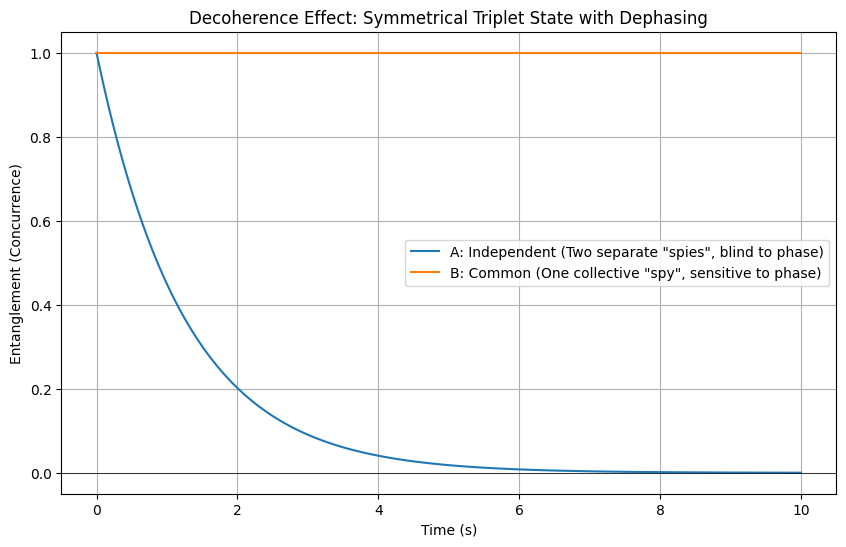

Rendering cityscape_Symmetrical_Triplet_State_Dephasing_independent.gif...


In [ ]:
simulate_sigma_z((ket("01") + ket("10")).unit(), "Symmetrical Triplet State")
simulate_sigma_m((ket("01") + ket("10")).unit(), "Symmetrical Triplet State")

In the first concurrence graph, you can see that the coherence in the seperate bath case rapidly declines, but the coherence in the common bath case stays constant at a value of 1. This means that the triplet state is insensitive to dephasing when both qubits are in the same bath. In the second concurrence graph, it is immediately clear that the environment noise has a large, negative effect on coherence in the triplet state for both bath models. As time passes, the lines for both the common bath (orange) and the seperate bath (blue) decline rapidly, indicating that coherence is quickly lost in both cases.<br><br>

### Case 2: Singlet Subsystem
In this case, we start with the maximally entangled singlet state ($\ket{\Psi_{-}} = \frac{\ket{01} - \ket{10}}{\sqrt{2}}$). The concurrence graphs can be seen below.

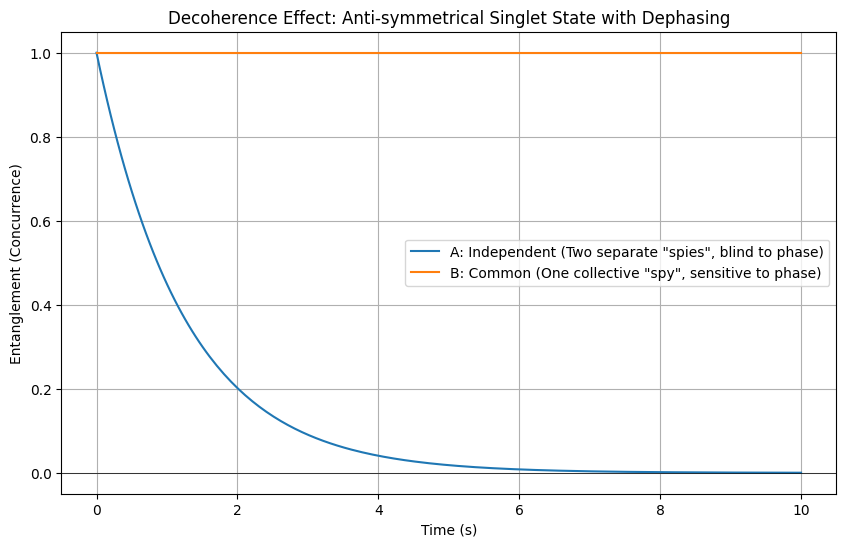

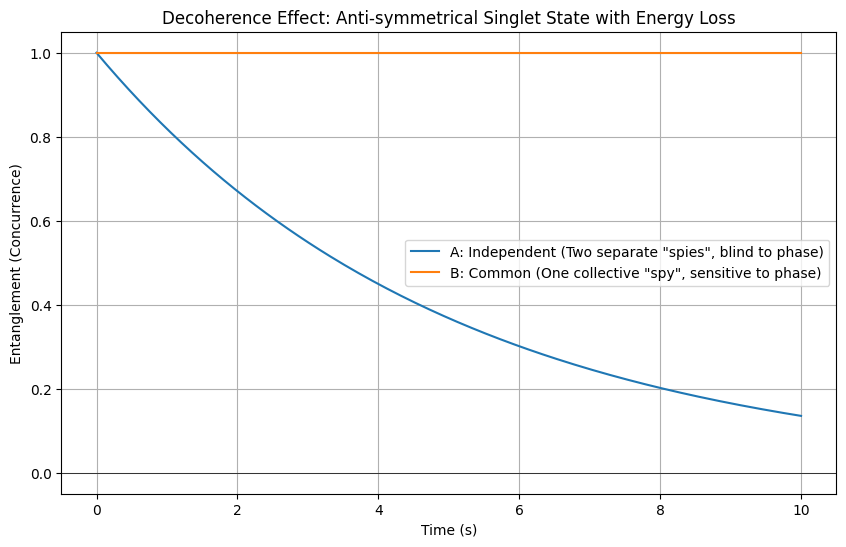

In [ ]:
simulate_sigma_z((ket("01") - ket("10")).unit(), "Anti-symmetrical Singlet State")
simulate_sigma_m((ket("01") - ket("10")).unit(), "Anti-symmetrical Singlet State")


The singlet state behaves the exact same way when dephasing occurs: the seperate bath case shows decoherence, yet the common bath case shows insensitivity to decoherence due to dephasing. When considering energy loss, differences start to show. Like the triplet state, the singlet state decoheres due to energy loss, when both qubits are in seperate baths. Unlike the triplet state, though, the singlet state does not decohere due to energy loss when both qubits are in the same bath. This means that, when both qubits feel the same noise, the singlet state does not decohere due to dephasing or energy loss.<br><br>

This is because of the anti-symmetrical nature of the singlet state. The singlet state ($\ket{\Psi_{-}} = \frac{\ket{01} - \ket{10}}{\sqrt{2}}$) is insensitive to dephasing in the common bath case. This is because $\sigma_{z}^{tot} \ket{\Psi_{-}} = (\sigma_{z}^{(1)} + \sigma_{z}^{(2)})(\ket{01} - \ket{10}) = (\sigma_{z}^{(1)} + \sigma_{z}^{(2)})(\ket{01}) - (\sigma_{z}^{(1)} + \sigma_{z}^{(2)})(\ket{10}) = \ket{01} - \ket{01} + \ket{10} - \ket{10} = 0$. A similar phenomenon is described by the experiment in the paper by _Governale et al (2001). "Decoherence and dephasing in coupled Josephson-junction qubits"_<br><br>
This state is also insensitive to decoherence due to energy loss. This is because $\sigma_{-}^{tot} \ket{\Psi_{-}} = (\sigma_{-}^{(1)} + \sigma_{-}^{(2)})(\ket{01} - \ket{10}) = (\sigma_{-}^{(1)} + \sigma_{-}^{(2)})(\ket{01}) - (\sigma_{-}^{(1)} + \sigma_{-}^{(2)})(\ket{10}) = \ket{11} - \ket{11} = 0$. The singlet subspace described here is an example of a Decoherence-Free Subspace (DFS), explored in detail by _Campagnano, G., Hamma, A., & Weiss, U. (2009). "Decoherence and entanglement dynamics of coupled qubits"_. <br><br> 

### Applying a X-gate to the system
To show how a DFS might be useful in practice, we will apply a X-gate in this example. First, we need to redefine our qubits. We have to combine both qubits in a particular way to create new "logical qubits". The reason why we need to do this can be seen in the Von Neumann entropy: For a pure state, the Von Neumann entropy is 0, per definition. This means that the state of the system is fully known. However, the seperate qubits have a Von Neumann entropy of $\ln{2}$. This is because the seperate qubits are in a maximally mixed state, which results in maximal entropy. Because of this, all stored information of this system is contained in the entanglement of the two qubits. So we need to find a way to compute with two qubits as if they were one qubit.<br><br>

We define the logical qubits as: $\ket{0_{L}} = \ket{01}$ and $\ket{1_{L}} = \ket{10}$. Using these definitions for the logical qubits, we can plot a "logical Bloch sphere". This works, like mentioned before, with the bloch() function in QuTiP. To use the logical qubits instead of the standard qubits inside the bloch sphere, we need to make some modifications. To change the standard 4x4 qubit matrix to the 2x2 logical qubit matrix, we manually extract the correct elements. Then, we plot the bloch sphere as usual. We apply a X-gate to this system and visualise the result with the bloch sphere. Below you can see this bloch sphere and a graph of the length of the vector inside the bloch sphere.


In [ ]:
interact(run_advanced_demo, 
         gamma_val=FloatSlider(min=0.0, max=1.0, step=0.1, value=0.3, description="Noise Strength"),
         enable_phase=Checkbox(value=True, description="Add Phase Noise (Z)"),
         enable_energy=Checkbox(value=False, description="Add Energy Loss (Sm)"),
         protection_mode=Dropdown(
             options=['Common Bath (DFS)', 'Separate Bath (Unprotected)'],
             value='Common Bath (DFS)',
             description='Mode:',
         )
);

interactive(children=(FloatSlider(value=0.3, description='Noise Strength', max=1.0), Checkbox(value=True, desc…


Inside the widget, you have control over the type of noise, the noise strength and the bath model. You can see that the system is fully protected against phase noise (the circle inside the bloch sphere, cause by the X gate, is unperturbed). Oddly enough, however, energy loss does seem to affect this system. This is counterintuitive when looking back at what we discussed before. The issue seems to be the choice of logical qubit. We restrict our system to states $\ket{0_{L}} = \ket{01}$ and $\ket{1_{L}} = \ket{10}$. However, the only state with a total spin of 0 is the singlet state. Thus, energy can still dissipate into the environment. One fix for this is scaling up to four qubits. With four qubits, we are able to create two states which have a total spin of 0: 2 pairs of singlets and a combination of triplet states with anti-parallel states. Redefining our logical qubits as a combination of 4 of these qubits would prevent this issue. _Lidar, D. A., Chuang, I. L., & Whaley, K. B. (1998). "Decoherence-free subspaces for quantum computation"_ introduces DFS construction using multiple qubits to span subspaces annihilated by collective noise operators.<br><br>

## Summary and Outlook
To summarize, we tested various combinations of subspaces and environments to find out which combination would be most resilient to noise. We found out that 2 qubits in the singlet subspace and in a common bath will completely resilient to dephasing and energy loss due to noise. However, to compute with this DFS protected case, we would have to use four qubits, to prevent energy loss due to noise.<br><br>

With more time, we would have liked to try and simulate a 4 qubit logical bit, to see if it really is protected against energy loss. If this were to be possible, quantum computing could change a lot. Instead of spending resources on Quantum Error Correction codes, we could inherently and passively prevent errors, by scaling up.<br><br>

## References

1. W. K. Wootters, "Entanglement of Formation of an Arbitrary State of Two Qubits," *Physical Review Letters*, vol. 80, no. 10, pp. 2245–2248, 1998.
2. G. Lindblad, "On the generators of quantum dynamical semigroups," *Communications in Mathematical Physics*, vol. 48, no. 2, pp. 119–130, 1976.
3. QuTiP documentation, mesolve function. Available: https://qutip.org/docs/4.0.2/modules/qutip/mesolve.html.
4. M. Governale, P. Schönheit, and U. Zülicke, "Decoherence and dephasing in coupled Josephson-junction qubits," *Chemical Physics*, vol. 268, no. 3, pp. 273–283, 2001.
5. G. Campagnano, A. Hamma, and U. Weiss, "Decoherence and entanglement dynamics of coupled qubits,", 2009.
6. D. A. Lidar, I. L. Chuang, and K. B. Whaley, "Decoherence-free subspaces for quantum computation," *Physical Review Letters*, vol. 81, no. 12, pp. 2594–2597, 1998.

## Author contributions

Matei Canavea - Code exepriments implemntation, referencing, report review <br><br>
Casian Chiriac - <br><br>
Teodor Neagoe - Qubit decoherence live simulations, cityscapes <br><br>
Ivo van der Dussen - Report and physical explanations<br><br>